# Carlini Wagner Attacks

In [1]:
import xlab
xlab.hello_world()

# get CIFAR10 helper functions 
from xlab.utils import CIFAR10
itos, stoi = CIFAR10.itos, CIFAR10.stoi

# for loading out model and data
from robustbench.utils import load_model
from robustbench.data import load_cifar10

# pytorch imports
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

# for plotting
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"You are using device: {device}")

Hello world! You are using version 0.1.7 of the package
You are using device: mps


In [2]:
# load our data
NUM_EXAMPLES = 100
x_test, y_test = load_cifar10(n_examples=NUM_EXAMPLES)
x_test, y_test = x_test.to(device), y_test.to(device)
print(f"{x_test.shape=}, {y_test.shape=}")

x_test.shape=torch.Size([100, 3, 32, 32]), y_test.shape=torch.Size([100])


We will begin by loading a pretrained model for classification on CIFAR using robustbench. This is a much larger more impressive model than the one you looked at in the previous section.

In [3]:
model = load_model(model_name='Standard', threat_model='Linf')
model = model.to('mps')
_ = model.eval()

First let's take a look at what we have. We can see that there is about 36.5 million trainable pameters in the model. This is actually quite large! For reference, we will be looking at the smallest version of GPT-2 later in the course. That has 128 million parameters, meaning our classifer is only a third of the size of the smallest transformer-based language models.

In [4]:
# print the parameter count
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")

Trainable parameters: 36,479,194


## Tasks 1-5: Writing the function $f(x + \delta)$

Recall that we will be using a loss to minimize the equation below.
$$
\ell = \mathcal{D}(x, x + \delta) + c \cdot f (x + \delta)
$$

The function $\mathcal{D}$ measures how different $x$ (the original image) is from $x + \delta$ where $\delta$ is the purtubations we are making to the image. In the original paper, Carlini and Wagner list seven of reasonable choices you could make for $f$. For brevity, you will only implement and compare 3 of them. 

Note that the equations below are presented slightly differently than in the original paper. They are all mathematically equivalent, but we have rewritten some for clarity. 

<details>
<summary>⚠️ <b>Caution</b></summary>

In this section we will have you implement 3 out of the 7 choices for $f$. We encourage you to implement the other choices of $f$ from [the paper](https://arxiv.org/pdf/1608.04644) if you are interested. We will caution you however that there appears to be a sign error in equation #1. The correct equation with the right signs should be shown below. Cross Entropy here will be taken with $\log_2$ rather than $\log_e$.

$$
f_1(x_{\mathrm{adversarial}}) = \mathrm{CrossEntropy}(F(x_{\mathrm{adversarial}})) - 1
$$

In general we find that the "Objective Function" section of the paper isn't very well written. For example they say that they "define an objective function $f$ such that $C(x + \delta) = t$ if and only if $f(x + \delta) \leq 0$." but it is trivial to show that equation 4 does not satisfy the "if and only if" condition.

</details>

### Task #1: Implementing $f_2$

The one thing you have to be careful about is the first term in this equation takes the greatest softmax probability that is not the target class. The reason this works is that the model will only predict class $t$ if the sofmax probability for it is greater than any other class.

The equation for $f_2$ is below. $F_t(x)$ is the model output for class $t$ including the [softmax](https://docs.pytorch.org/docs/stable/generated/torch.nn.Softmax.html) which gives probabilities rather than logits. 

$$
f_2(x_{\mathrm{adversarial}}) = \mathrm{ReLU}(\max_{i \neq t}(F(x_{\mathrm{adversarial}})) - F_t(x_{\mathrm{adversarial}}))
$$

In [5]:
def f2(logits, target):
    softmax_probs = F.softmax(logits, dim=0)
    i_neq_t = torch.argmax(softmax_probs)
    if i_neq_t == target:
        i_neq_t = torch.argmax(torch.cat([softmax_probs[:target], softmax_probs[target+1:]]))
    return F.relu(softmax_probs[i_neq_t] - softmax_probs[target])

In [6]:
x = torch.tensor([1.0, 3.0])
print(f2(x, 0)) # should be >0
x = torch.tensor([1.0, 1.0])
print(f2(x, 0)) # should be =0
x = torch.tensor([3.0, 1.0])
print(f2(x, 0)) # should be =0

tensor(0.7616)
tensor(0.)
tensor(0.)


### Task #2: Implementing $f_4$

This is similar to the equation above. The only difference is that we are inforcing the requirement that the target class has a probability greater than or equal to 0.5 rather a probability greater than or equal to any of the other classes.

$$
f_4(x_{\mathrm{adversarial}}) = \mathrm{ReLU}(0.5 - F_t(x_{\mathrm{adversarial}}))
$$

In [7]:
def f4(logits, target):
    softmax_probs = F.softmax(logits, dim=0)
    return F.relu(0.5 - softmax_probs[target])

In [8]:
x = torch.tensor([1.0, 3.0])
print(f4(x, 0)) # should be >0
x = torch.tensor([1.0, 1.0])
print(f4(x, 0)) # should be =0
x = torch.tensor([3.0, 1.0])
print(f4(x, 0)) # should be =0

tensor(0.3808)
tensor(0.)
tensor(0.)


### Task #3: Implementing $f_6$

This is very similar ot $f_2$. The difference is we use $Z_t(x)$ instead of $F_t(x)$. $Z_t(x)$ is the raw output of the model for class $t$ rather than the output after the softmax.

$$
f_6(x_{\mathrm{adversarial}}) = \mathrm{ReLU}(\max_{i \neq t}(Z(x_{\mathrm{adversarial}})) - Z_t(x_{\mathrm{adversarial}}))
$$

In [9]:
def f6(logits, target):
    # softmax_probs = F.softmax(logits, dim=0)
    i_neq_t = torch.argmax(logits)
    if i_neq_t == target:
        i_neq_t = torch.argmax(torch.cat([logits[:target], logits[target+1:]]))
    return F.relu(logits[i_neq_t] - logits[target])

In [10]:
x = torch.tensor([1.0, 3.0])
print(f6(x, 0)) # should be >0
x = torch.tensor([1.0, 1.0])
print(f6(x, 0)) # should be =0
x = torch.tensor([3.0, 1.0])
print(f6(x, 0)) # should be =0

tensor(2.)
tensor(0.)
tensor(0.)


By now you should have several options for $f$. Now we can optimize the below equation below where we let $\mathcal{D}(x, x + \delta)$ be the $L_2$ norm.

$$
\ell = \mathcal{D}(x, x + \delta) + c \cdot f (x + \delta)
$$


We have implemented this below for you. The attack is extremely similar to the PGD attack you coded in the previous notebook so it should look familiar to you. Still, you should read through the code and make sure you understand everything!

In [11]:
def cw_loss_v1(f, x, y, delta, c, model):
    logits = model(x + delta)
    f_loss = f(logits[0], y)
    norm_loss = torch.sum(delta**2)

    return norm_loss + c * f_loss

def cw_simple(f, x, y, c, model, num_iters):
    delta = torch.randn_like(x) * 0.1
    delta.requires_grad = True
    optimizer = optim.Adam([delta], lr=1e-2)

    for i in range(num_iters):
        l = cw_loss_v1(f, x, y, delta, c, model)
        l.backward()
        optimizer.step()
        optimizer.zero_grad()
        if (i + 1) % 5 == 0:
            print(f"iteration {i + 1}:\t loss={l.item():.4f}")
    return x + delta

### Task #4: Test different $f$ functions

The next step is to fill in the missing code below to test how effective different choices of $f$ are. When running `benchmark_f` for `f2`, `f4` and `f6` you should find that one choice of $f$ is much more effective than the other two.

<details>
<summary>💡 <b>Hint </b></summary>

$f_6$ Should have 100% attack success rate for the 5 images we selected. When we run our code we get:

* f2_results = [6, 1, 1, 1, 6]
* f4_results = [3, 1, 1, 0, 6]
* f6_results = [1, 1, 1, 1, 1]

</details>

In [12]:
def benchmark_f(f, num_imgs=5, num_iters=40, target_class=1, c=1):
    print(f"running attacks on {num_imgs} images with target='{itos[target_class]}'")

    results = []
    for i in range(num_imgs):
        x_clean = x_test[i:i+1].to(device) # tensor is [1, 3, 32, 32]
        
        adv_image = cw_simple(f, x_clean, target_class, c, model, num_iters) ### YOUR CODE HERE ###
        predicted_class = torch.argmax(model(adv_image)).item() ### YOUR CODE HERE ###
        print(f"model predicts class 'target='{itos[predicted_class]}'")
        results.append(predicted_class)

    return results

In [21]:
f2_results = benchmark_f(f2)

In [22]:
f4_results = benchmark_f(f4)

In [23]:
f6_results = benchmark_f(f6)

In [17]:
_ = xlab.tests.section2_1_2.task4(f2_results, f4_results, f6_results, 1)

Running tests for Section 2.1.2, Task 4...

✓ 1. Test case arrays have equal length                        PASSED
     Array lengths: 5, 5, 5
✓ 2. Test case third array has most occurrences                PASSED
     Target value: 1
     Array1 count: 3
     Array2 count: 2
     Array3 count: 5 (highest)

🎉 All tests passed! (2/2)


## Choosing a value for $c$

In the previous section you should have seen that the we picked a hardcoded value for $c$. But is there a better strategy than guessing? In the paper, the authors say:

<blockquote>
    Empirically, we have found taht often the best way to choose $c$ is to use the smallest value of $c$ for which the resulting solution $x^{*}$ has $f(x^{*}) \leq 0$. This causes gradient descent to minimize both of the terms simultaneously instead of picking only one to optimize over first.
</blockquote>

In other words, to find the idea result, we want our optimizer to make improvements that maximize the $f$ function but have the minimum possible impact on the $L_p$ norm. If the $c$ value is too larger, the $f$ function will dominate the loss and the optimizer may allow for a larger $L_p$ norm than is strictly necessary. If $c$ is too small, the attack won't be successful. By choosing the smallest possible $c$ that makes the attack successful, we get the best of both worlds.

In the code below you will benchmark different $c$ values for a small subset of CIFAR 10.

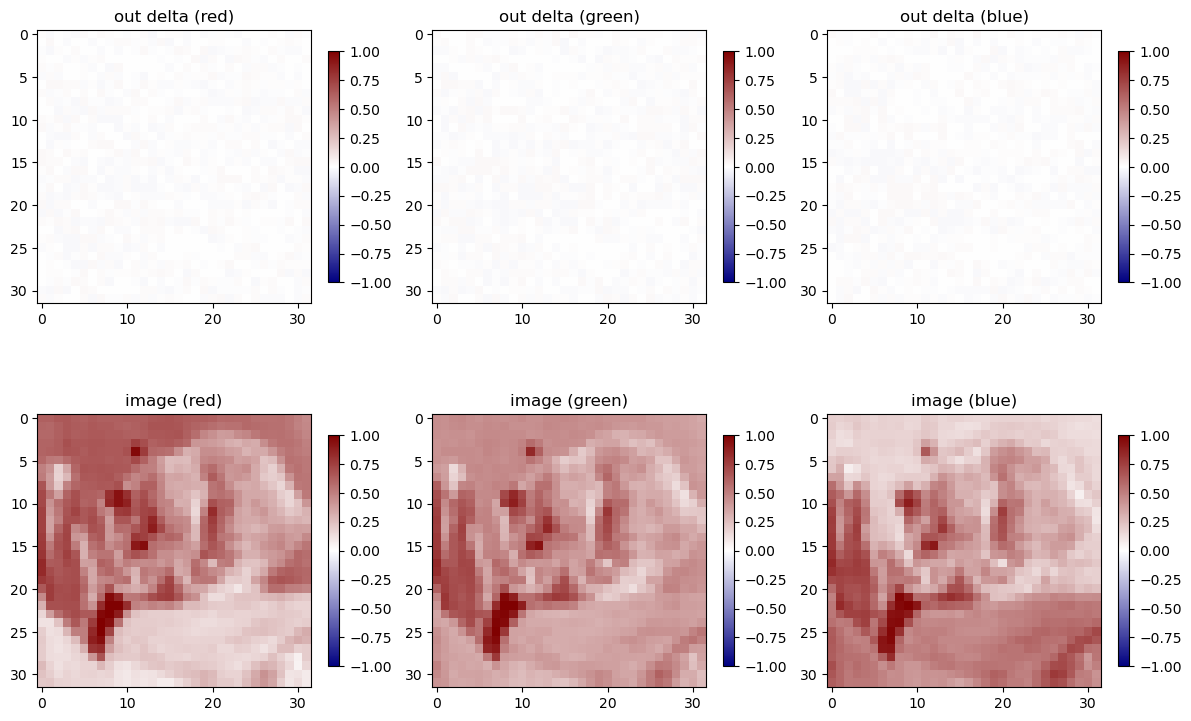

In [352]:
adv = adv[0].detach().cpu()
x = x_test[0].detach().cpu()
delta = adv - x

_ = xlab.utils.plot_tensors(
    [delta[0], delta[1], delta[2], x.cpu()[0], x.cpu()[1], x.cpu()[2]],
    log_scale=False, 
    ncols=3,
    # log_scale=True,
    titles = ["out delta (red)", "out delta (green)", "out delta (blue)", "image (red)", "image (green)", "image (blue)"]
)

In [300]:
torch.argmax(model(adv))

RuntimeError: slow_conv2d_forward_mps: input(device='cpu') and weight(device=mps:0')  must be on the same device

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.050887734..1.0007143].


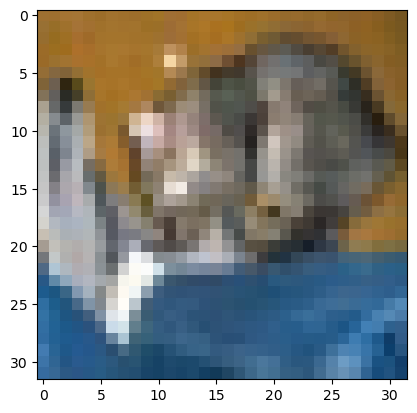

In [283]:
plt.imshow(adv[0].detach().cpu().permute(1,2,0))

In [ ]:
F.cross_entropy(torch.tensor([1.0, 2, 3]), torch.tensor(1))

In [135]:
torch.log(F.softmax(torch.tensor([1.0, 2, 3]), dim=0))

tensor([-2.4076, -1.4076, -0.4076])

$$
f_1(x_{\mathrm{adversarial}}) = -C(F(x_{\mathrm{adversarial}})) + 1
$$

In [2]:
model = load_model(model_name='Standard', threat_model='Linf')
model = model.to('mps')
_ = model.eval()

In [3]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")

Trainable parameters: 36,479,194


In [4]:
NUM_EXAMPLES = 100
x_test, y_test = load_cifar10(n_examples=NUM_EXAMPLES)
x_test, y_test = x_test.to(device), y_test.to(device)
print(f"{x_test.shape=}, {y_test.shape=}")

x_test.shape=torch.Size([100, 3, 32, 32]), y_test.shape=torch.Size([100])


In [152]:
def f_6(logits, target, k=0):
    i_neq_t = torch.argmax(logits)
    if i_neq_t == target:
        i_neq_t = torch.argmax(torch.cat([logits[:target], logits[target+1:]]))
    print("in f6", (logits[i_neq_t] - logits[target]).item())
    return torch.max(logits[i_neq_t] - logits[target], -torch.tensor(k))
            

def CW_targeted_l2(img, model, c, target, k=1):
    
    cw_weights = torch.randn_like(img).to('mps') * 0.001
    cw_weights.requires_grad = True
    optimizer = optim.Adam([cw_weights], lr=5e-2)

    num_iters = 100
    delta = 0.5 * (F.tanh(cw_weights) + 1) - img

    k = 0.1

    for i in range(num_iters):
        
        logits = model((img + delta).unsqueeze(0))

        if torch.argmax(logits[0]) == target and torch.sum((delta)**2) <= 0.5:
            return delta

        # print(f_6(logits[0], target))
        assert f_6(logits[0], target, k) >= -k
        success_loss = c * f_6(logits[0], target, k)
        l2_reg = torch.sum((delta)**2)

        loss = success_loss + l2_reg
        print(loss, success_loss, l2_reg)
        
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        delta = 0.5 * (F.tanh(cw_weights) + 1) - img
    print("warning! targeted attack was not successful")
    return delta

In [153]:
torch.max(torch.tensor(5), torch.tensor(-2))

tensor(5)

In [154]:
x = x_test[0]

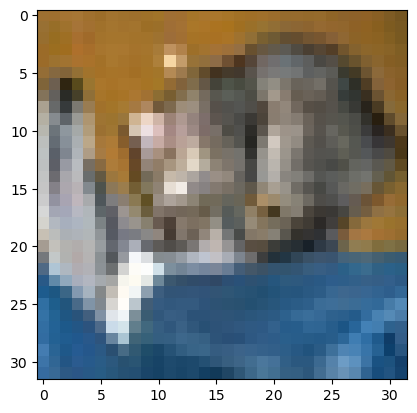

In [155]:
plt.imshow(x.permute(1,2,0).cpu())

In [156]:
out_delta = CW_targeted_l2(x.to('mps'), model, 0.01, 1)

in f6 7.889273643493652
in f6 7.889273643493652
tensor(120.1354, device='mps:0', grad_fn=<AddBackward0>) tensor(0.0789, device='mps:0', grad_fn=<MulBackward0>) tensor(120.0565, device='mps:0', grad_fn=<SumBackward0>)
in f6 8.08248233795166
in f6 8.08248233795166
tensor(97.0092, device='mps:0', grad_fn=<AddBackward0>) tensor(0.0808, device='mps:0', grad_fn=<MulBackward0>) tensor(96.9284, device='mps:0', grad_fn=<SumBackward0>)
in f6 14.96743392944336
in f6 14.96743392944336
tensor(77.6946, device='mps:0', grad_fn=<AddBackward0>) tensor(0.1497, device='mps:0', grad_fn=<MulBackward0>) tensor(77.5449, device='mps:0', grad_fn=<SumBackward0>)
in f6 4.813962936401367
in f6 4.813962936401367
tensor(61.6276, device='mps:0', grad_fn=<AddBackward0>) tensor(0.0481, device='mps:0', grad_fn=<MulBackward0>) tensor(61.5795, device='mps:0', grad_fn=<SumBackward0>)
in f6 1.4890851974487305
in f6 1.4890851974487305
tensor(48.6323, device='mps:0', grad_fn=<AddBackward0>) tensor(0.0149, device='mps:0', gra

In [157]:
out_delta.shape

torch.Size([3, 32, 32])

In [158]:
8/255

0.03137254901960784

In [159]:
out_delta.min(), out_delta.max()

(tensor(-0.0629, device='mps:0', grad_fn=<MinBackward1>),
 tensor(0.0464, device='mps:0', grad_fn=<MaxBackward1>))

In [160]:
max_diff = torch.max(torch.abs(out_delta))

In [161]:
max_diff

tensor(0.0629, device='mps:0', grad_fn=<MaxBackward1>)

In [119]:
assert max_diff < 8/255

Now let's plot what we have. You should 

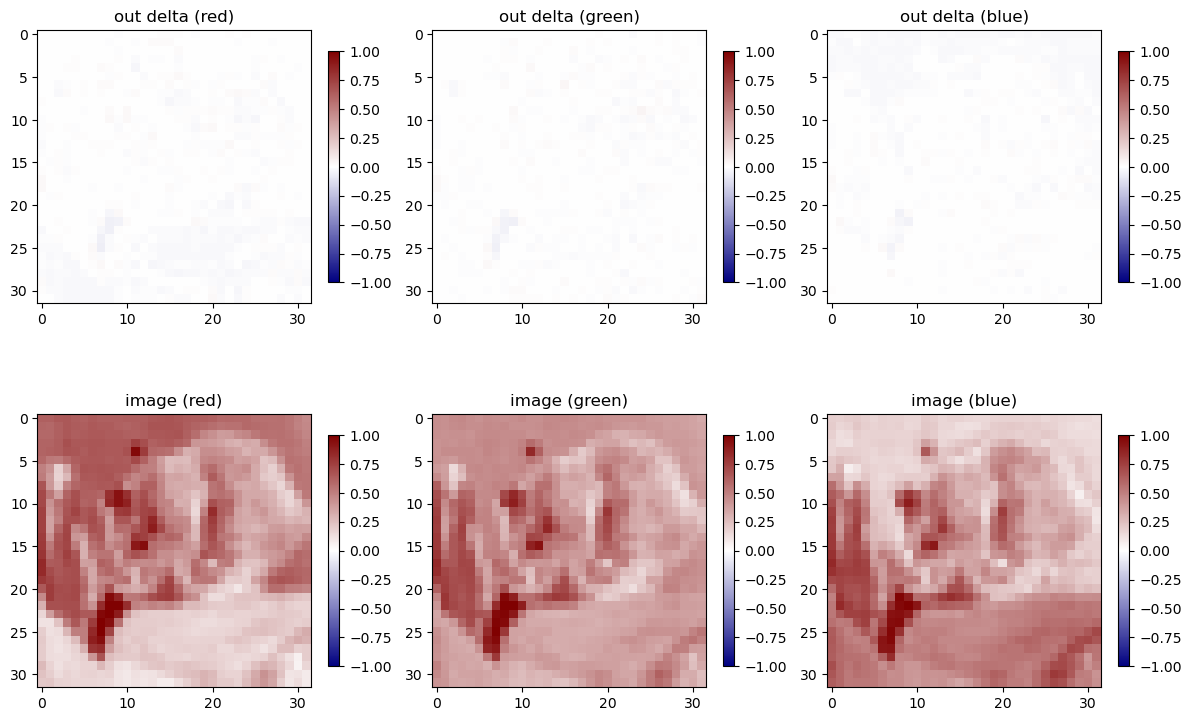

In [162]:
out_delta = out_delta.detach().cpu()

_ = xlab.utils.plot_tensors(
    [out_delta[0], out_delta[1], out_delta[2], x.cpu()[0], x.cpu()[1], x.cpu()[2]],
    log_scale=False, 
    ncols=3,
    # log_scale=True,
    titles = ["out delta (red)", "out delta (green)", "out delta (blue)", "image (red)", "image (green)", "image (blue)"]
)

In [43]:
x_adv = out_delta + x

In [44]:
model(x_adv.unsqueeze(0))

tensor([[13.4251, -0.7176, -1.3678,  3.0889, -5.2713, -1.6484, -1.6464, -2.5078,
         -1.8055, -1.4932]], device='mps:0', grad_fn=<LinearBackward0>)

In [45]:
x_adv.shape

torch.Size([3, 32, 32])

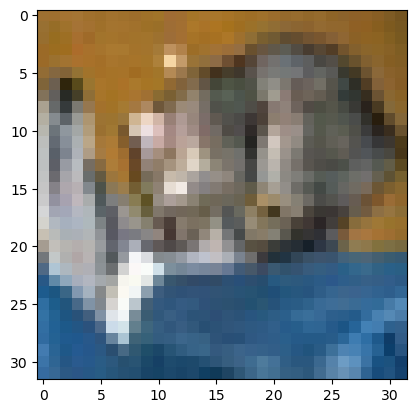

In [46]:
plt.imshow(x_adv.detach().permute(1,2,0).cpu())

## Choosing a constant $c$


<blockquote>
    Empirically, we have found that often the best way to choose
$c$ is to use the smallest value of $c$ for which the resulting
solution $x^{*}$ has $f(x^{*}
)\leq 0$. This causes gradient descent to
minimize both of the terms simultaneously instead of picking
only one to optimize over first.
</blockquote>



On choosing a good $f$:

<blockquote>
The choice of method
for handling box constraints does not impact the quality of
results as significantly for the best minimization functions.
</blockquote>